## DC1 Simple PSF Tests

Some simple tests of the DC1 PSF. This notebook makes use of some of the LSST stack packages (i.e., `daf`). An example kernel that loads these is available in [lsst-kernel.sh](./lsst-kernel.sh).

Validated by [@kadrlica](https://github.com/kadrlica): 2017-12-06

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import lsst.daf.persistence
DATA_DIR_DITHERED_NEW = "/global/cscratch1/sd/descdm/DC1/rerun/DC1-imsim-dithered"
DATA_DIR_PHOSIM = "/global/cscratch1/sd/descdm/DC1/DC1-phoSim-3a"
DATA_DIR_UNDITHERED_NEW = "/global/cscratch1/sd/descdm/DC1/rerun/DC1-imsim-undithered"

os.environ['OMP_NUM_THREADS']='1'

In [2]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED_NEW)

In [3]:
%%time
datarefs = butler.subset('calexp')
# This cell will take several minutes the first time you run it, but will be fast afterwards

CPU times: user 8.2 s, sys: 3.11 s, total: 11.3 s
Wall time: 33.5 s


In [4]:
import sqlite3
from sqlite3 import Error
 
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [5]:
conn = create_connection('/global/projecta/projectdirs/lsst/groups/SSim/DC1/minion_1016_sqlite_new_dithers.db')

In [6]:
def get_airmass_raw_seeing(conn,visit):
    cur = conn.cursor()
    cur.execute("SELECT airmass, filtSkyBrightness, finSeeing, rawSeeing, visitExpTime, fiveSigmaDepth FROM ObsHistory WHERE obsHistID==%d" %(visit))
    rows = cur.fetchall()
    return rows[0][0], rows[0][1], rows[0][2], rows[0][3], rows[0][4], rows[0][5]

In [7]:
len(datarefs.cache)

183767

In [8]:
%%time
av_psf = np.zeros((41,41))
# Take a subsample of datarefs so that this doesn't take forever
for i in np.arange(len(datarefs.cache))[::10000]:
    #Datarefs.cache used to print the correct format for sensor and raft. I hacked my way in...
    sensor = datarefs.cache[i]['sensor'][0]+','+datarefs.cache[i]['sensor'][1]
    raft = datarefs.cache[i]['raft'][0]+','+datarefs.cache[i]['raft'][1]
    test_calexp = butler.get('calexp',filter='r',visit=datarefs.cache[i]['visit'],raft=raft,sensor=sensor,immediate=True)
    av_psf = av_psf + test_calexp.getPsf().computeImage().getArray()

CPU times: user 1.65 s, sys: 1.97 s, total: 3.61 s
Wall time: 3.63 s


In [9]:
import galsim
class PSFbase(object):
    """
    This is the base class for wrappers of GalSim's PSF classes.  To apply a PSF to GalSim images
    using the GalSim Instance Catalog and GalSim Interpreter, the user must define a daughter
    class of this class and instantiate it as the member variable self.PSF in the GalSim Instance Catalog.
    Any Daughter class of this class must have a member method _getPSF which accepts the coordinates
    xPupil and yPupil in arcseconds as kwargs.  This method will instantiate a psf object at those
    coordinates and return it.
    The method applyPSF is defined in this class and should not be overwritten.  It handles the task of actually
    convolving the PSF returned by _getPSF.
    Consult GalSim's documentation to see what kinds of PSFs are available.
    See the classes DoubleGaussianPSF and SNRdocumentPSF below for example implementations.
    See galSimCompoundGenerator.py and galSimStarGenerator.py for example usages.
    """

    def _getPSF(self, xPupil=None, yPupil=None):
        """
        If it had been implemented, this would return a GalSim PSF instantiation at the
        coordinates and wavelength specified and returned it to applyPSF.  As it is, this
        class has not been implemented and is left to the user to implement in Daughter
        classes of PSFbase.
        @param [in] xPupil the x coordinate on the pupil in arc seconds
        @param [in] yPupil the y coordinate on the pupil in arc seconds
        """

        raise NotImplementedError("There is not _getPSF for PSFbase; define a daughter class and define your own")

    def applyPSF(self, xPupil=None, yPupil=None, obj=None, **kwargs):
        """
        Apply the PSF to a GalSim GSObject
        This method accepts the x and y pupil coordinates in arc seconds as well
        as a GalSim GSObject.  The method calculates the PSF parameters based on xPupil
        and yPupil, constructs a Galsim GSObject corresponding to the PSF function, and convolves
        the PSF with the GSObject, returning the result of the convolution.
        In the case of point sources, this object returns the raw PSF, rather than attempting
        a convolution (since there is nothing to convolve with).
        @param [in] xPupil the x pupil coordinate in arc seconds
        @param [in] yPupil the y pupil coordinate in arc seconds
        @param [in] obj is a GalSim GSObject (an astronomical object) with which
        to convolve the PSF (optional)
        """

        #use the user-defined _getPSF method to calculate the PSF at these specific
        #coordinates and (optionally) wavelength
        psf = self._getPSF(xPupil=xPupil, yPupil=yPupil, **kwargs)

        if obj is not None:
            #if we are dealing with an extended object, convolve it with the psf
            obj = galsim.Convolve(obj, psf)
            return obj
        else:
            #if there is no object (i.e. if this is a point source), just return the PSF
            return psf

class Kolmogorov_and_Gaussian_PSF(PSFbase):
    """
    This PSF class is based on David Kirkby's presentation to the DESC Survey Simulations
    working group on 23 March 2017.
    https://confluence.slac.stanford.edu/pages/viewpage.action?spaceKey=LSSTDESC&title=SSim+2017-03-23
    (you will need a SLAC Confluence account to access that link)
    """

    def __init__(self, airmass=1.2, rawSeeing=0.7, band='r'):
        """
        Parameters
        ----------
        airmass
        rawSeeing is the FWHM seeing at zenith at 500 nm in arc seconds
        (provided by OpSim)
        band is the bandpass of the observation [u,g,r,i,z,y]
        """
        # This code was provided by David Kirkby in a private communication

        wlen_eff = dict(u=365.49, g=480.03, r=622.20, i=754.06, z=868.21, y=991.66)[band]
        # wlen_eff is from Table 2 of LSE-40 (y=y2)

        FWHMatm = rawSeeing * (wlen_eff / 500.) ** -0.3 * airmass ** 0.6
        # From LSST-20160 eqn (4.1)

        FWHMsys = np.sqrt(0.25**2 + 0.3**2 + 0.08**2) * airmass ** 0.6
        # From LSST-20160 eqn (4.2)

        atm = galsim.Kolmogorov(fwhm=FWHMatm)
        sys = galsim.Gaussian(fwhm=FWHMsys)
        psf = galsim.Convolve((atm, sys))

        self._cached_psf = psf
    def _getPSF(self, xPupil=None, yPupil=None):
        return self._cached_psf

In [10]:
#psf_input = Kolmogorov_and_Gaussian_PSF(airmass=meta.get('BORE-AIRMASS'),
#                                        rawSeeing=meta.get('DOMESEE'),
#                                        band='r')

psf_input = Kolmogorov_and_Gaussian_PSF(airmass=1.2,
                                        rawSeeing=0.7,
                                        band='r')

In [11]:
test = psf_input._getPSF()

In [12]:
def get_psf_array(calexp):
    return calexp.getPsf().computeImage().getArray()

In [13]:
def get_visit_PSF(repo_path,nvisits=0):
    butler = lsst.daf.persistence.Butler(repo_path)
    datarefs = butler.subset('calexp')
    if nvisits==0:
        visits = datarefs.cache
    else:
        indices = np.random.choice(range(len(datarefs.cache)),size=nvisits)
        visits = np.array(datarefs.cache)[indices]
    psf_input = []
    psf_output = []
    visit_X = []
    visit_seeing = []
    for i,visitId in enumerate(visits):
        try:
            #This used to work without these two lines below...
            sensor = visitId['sensor'][0]+','+visitId['sensor'][1]
            raft = visitId['raft'][0]+','+visitId['raft'][1]
            visitId['sensor']=sensor
            visitId['raft']=raft
            ##################
            calexp = butler.get('calexp',visitId)
            psf_output.append(get_psf_array(calexp))
            X, sky, fwhm, rawseeing, exptime, depth_opsim = get_airmass_raw_seeing(conn,visitId['visit'])
            psf = Kolmogorov_and_Gaussian_PSF(airmass=X,rawSeeing=rawseeing,band='r')
            aux = psf._getPSF()
            psf_input.append(aux.drawImage(nx=41,ny=41,scale=0.2, use_true_center=False).array)
            visit_seeing.append(rawseeing)
            visit_X.append(X)
        except:
            print('File not found')
            continue
    return psf_output, psf_input, visit_seeing, visit_X

In [14]:
psf_out, psf_in, FWHM, X= get_visit_PSF(DATA_DIR_DITHERED_NEW,nvisits=10)

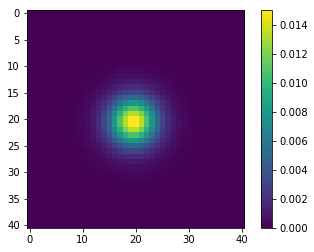

In [15]:
plt.imshow(psf_out[0],interpolation='none')
plt.colorbar()

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


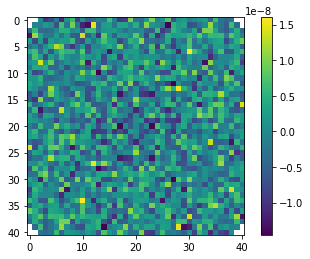

In [16]:
plt.imshow(np.mean(psf_out/np.sum(psf_out,axis=0)-psf_in/np.sum(psf_in,axis=0),axis=0),interpolation='none')
plt.colorbar()